# **Homework 2 Phoneme Classification**

* Slides: https://docs.google.com/presentation/d/1v6HkBWiJb8WNDcJ9_-2kwVstxUWml87b9CnA16Gdoio/edit?usp=sharing
* Kaggle: https://www.kaggle.com/c/ml2022spring-hw2
* Video: TBA


* https://zhuanlan.zhihu.com/p/483475612
* https://github.com/yl-jiang/ML2022SpringHW

preprocess_data 的 keep_ratio 只是暫解

當有足夠的 ram 或改為讀檔的方式後

便可移除，直接對所有資料訓練

In [1]:
!nvidia-smi

Wed Mar 29 12:33:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download Data
Download data from google drive, then unzip it.

You should have
- `libriphone/train_split.txt`
- `libriphone/train_labels`
- `libriphone/test_split.txt`
- `libriphone/feat/train/*.pt`: training feature<br>
- `libriphone/feat/test/*.pt`:  testing feature<br>

after running the following block.

> **Notes: if the links are dead, you can download the data directly from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw2/data) and upload it to the workspace, or you can use [the Kaggle API](https://www.kaggle.com/general/74235) to directly download the data into colab.**


### Download train/test metadata

In [2]:
%%script false --no-raise-error

# colab
# Main link
!wget -O libriphone.zip "https://github.com/xraychen/shiny-robot/releases/download/v1.0/libriphone.zip"

# Backup Link 0
# !pip install --upgrade gdown
# !gdown --id '1o6Ag-G3qItSmYhTheX6DYiuyNzWyHyTc' --output libriphone.zip

# Backup link 1
# !pip install --upgrade gdown
# !gdown --id '1R1uQYi4QpX0tBfUWt2mbZcncdBsJkxeW' --output libriphone.zip

# Backup link 2
# !wget -O libriphone.zip "https://www.dropbox.com/s/wqww8c5dbrl2ka9/libriphone.zip?dl=1"

# Backup link 3
# !wget -O libriphone.zip "https://www.dropbox.com/s/p2ljbtb2bam13in/libriphone.zip?dl=1"

!unzip -q libriphone.zip
!ls libriphone

### Preparing Data

**Helper functions to pre-process the training data from raw MFCC features of each utterance.**

A phoneme may span several frames and is dependent to past and future frames. \
Hence we concatenate neighboring phonemes for training to achieve higher accuracy. The **concat_feat** function concatenates past and future k frames (total 2k+1 = n frames), and we predict the center frame.

Feel free to modify the data preprocess functions, but **do not drop any frame** (if you modify the functions, remember to check that the number of frames are the same as mentioned in the slides)

In [3]:
import os
import random
import pandas as pd
import torch
from tqdm import tqdm

def load_feat(path):
    feat = torch.load(path)
    return feat

def shift(x, n):
    if n < 0:
        left = x[0].repeat(-n, 1)
        right = x[:n]

    elif n > 0:
        right = x[-1].repeat(n, 1)
        left = x[n:]
    else:
        return x

    return torch.cat((left, right), dim=0)

def concat_feat(x, concat_n):
    assert concat_n % 2 == 1 # n must be odd
    if concat_n < 2:
        return x
    seq_len, feature_dim = x.size(0), x.size(1)
    x = x.repeat(1, concat_n) 
    x = x.view(seq_len, concat_n, feature_dim).permute(1, 0, 2) # concat_n, seq_len, feature_dim
    mid = (concat_n // 2)
    for r_idx in range(1, mid+1):
        x[mid + r_idx, :] = shift(x[mid + r_idx], r_idx)
        x[mid - r_idx, :] = shift(x[mid - r_idx], -r_idx)

    return x.permute(1, 0, 2).view(seq_len, concat_n * feature_dim) # seq_len, concat_n, feature_dim

def preprocess_data(split, feat_dir, phone_path, concat_nframes, train_ratio=0.8, train_val_seed=1337, keep_ratio=1.0):
    class_num = 41 # NOTE: pre-computed, should not need change
    mode = 'train' if (split == 'train' or split == 'val') else 'test'

    label_dict = {}
    if mode != 'test':
        phone_file = open(os.path.join(phone_path, f'{mode}_labels.txt')).readlines()

        for line in phone_file:
            line = line.strip('\n').split(' ')
            label_dict[line[0]] = [int(p) for p in line[1:]]

    if split == 'train' or split == 'val':
        # split training and validation data
        usage_list = open(os.path.join(phone_path, 'train_split.txt')).readlines()
        random.seed(train_val_seed)
        random.shuffle(usage_list)
        percent = int(len(usage_list) * train_ratio)
        if split == 'train':
            usage_list = usage_list[:percent]  
#             usage_list = usage_list[:int(len(usage_list)*keep_ratio)]
            usage_list = usage_list[int(len(usage_list)*(1-keep_ratio)):]
        else:
            usage_list = usage_list[percent:]
    elif split == 'test':
        usage_list = open(os.path.join(phone_path, 'test_split.txt')).readlines()
    else:
        raise ValueError('Invalid \'split\' argument for dataset: PhoneDataset!')

    usage_list = [line.strip('\n') for line in usage_list]
    print('[Dataset] - # phone classes: ' + str(class_num) + ', number of utterances for ' + split + ': ' + str(len(usage_list)))

    max_len = 3000000
    X = torch.empty(max_len, 39 * concat_nframes)
    if mode != 'test':
        y = torch.empty(max_len, dtype=torch.long)

    idx = 0
    for i, fname in tqdm(enumerate(usage_list)):
        feat = load_feat(os.path.join(feat_dir, mode, f'{fname}.pt'))
        cur_len = len(feat)
        feat = concat_feat(feat, concat_nframes)
        if mode != 'test':
            label = torch.LongTensor(label_dict[fname])

        X[idx: idx + cur_len, :] = feat
        if mode != 'test':
            y[idx: idx + cur_len] = label

        idx += cur_len
        assert idx < max_len

    X = X[:idx, :]
    if mode != 'test':
        y = y[:idx]

    print(f'[INFO] {split} set')
    print(X.shape)
    if mode != 'test':
        print(y.shape)
        return X, y
    else:
        return X


In [4]:
x = torch.Tensor([[1,2,3,4,5],[11,12,13,14,15],[21,22,23,24,25],[31,32,33,34,35],[41,42,43,44,45],[51,52,53,54,55]])
y = concat_feat(x, 3).view(6, 3, 5)
x, y, y.view(6, -1)

(tensor([[ 1.,  2.,  3.,  4.,  5.],
         [11., 12., 13., 14., 15.],
         [21., 22., 23., 24., 25.],
         [31., 32., 33., 34., 35.],
         [41., 42., 43., 44., 45.],
         [51., 52., 53., 54., 55.]]),
 tensor([[[ 1.,  2.,  3.,  4.,  5.],
          [ 1.,  2.,  3.,  4.,  5.],
          [11., 12., 13., 14., 15.]],
 
         [[ 1.,  2.,  3.,  4.,  5.],
          [11., 12., 13., 14., 15.],
          [21., 22., 23., 24., 25.]],
 
         [[11., 12., 13., 14., 15.],
          [21., 22., 23., 24., 25.],
          [31., 32., 33., 34., 35.]],
 
         [[21., 22., 23., 24., 25.],
          [31., 32., 33., 34., 35.],
          [41., 42., 43., 44., 45.]],
 
         [[31., 32., 33., 34., 35.],
          [41., 42., 43., 44., 45.],
          [51., 52., 53., 54., 55.]],
 
         [[41., 42., 43., 44., 45.],
          [51., 52., 53., 54., 55.],
          [51., 52., 53., 54., 55.]]]),
 tensor([[ 1.,  2.,  3.,  4.,  5.,  1.,  2.,  3.,  4.,  5., 11., 12., 13., 14.,
          15.],
  

## Define Dataset

In [5]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class LibriDataset(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.data = X
        self.tf = transforms
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        data = self.data[idx]
        if self.tf:                                                   #    (concat_nframes*features)
            data = data.view(-1, 39).permute(1,0)                     # => (concat_nframes, features)    => (features, concat_nframes)
            data = self.tf(data.unsqueeze(0)).squeeze(0)              # => (1, features, concat_nframes) => (features, concat_nframes)
            data = data.permute(1,0).flatten()                         # => (concat_nframes, features)    => (concat_nframes*features)
        
        if self.label is not None:            
            return data, self.label[idx]
        else:
            return data

    def __len__(self):
        return len(self.data)


## Define Model

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

DEVICE: cuda:0


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
%%script false --no-raise-error

class BasicBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.BatchNorm1d(output_dim),
            nn.Dropout(0.25)
        )

    def forward(self, x):
        x = self.block(x)
        return x


class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim=41, hidden_layers=1, hidden_dim=256):
        super(Classifier, self).__init__()

        self.fc = nn.Sequential(
            BasicBlock(input_dim, hidden_dim),
            *[BasicBlock(hidden_dim, hidden_dim) for _ in range(hidden_layers)],
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

### CNN

In [9]:
%%script false --no-raise-error

class Classifier_CNN(nn.Module):
    def __init__(self, concat_nframes, input_channel=39, output_dim=41):
        super(Classifier_CNN, self).__init__()
        
        # (batch, 39, concat_nframes)
        self.conv = nn.Sequential(
            nn.Conv1d(input_channel, 64, 5, stride=1, padding=2),   # (batch, 64, concat_nframes)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2), # !important for overfitting
            
            nn.Conv1d(64, 128, 5, stride=1, padding=2),             # (batch, 128, concat_nframes)
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2), # !important for overfitting
            
            nn.Conv1d(128, 256, 5, stride=1, padding=2),            # (batch, 256, concat_nframes)
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2), # !important for overfitting
            
            nn.Conv1d(256, 512, 5, stride=1, padding=2),            # (batch, 512, concat_nframes)
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2), # !important for overfitting
            
            nn.Conv1d(512, 1024, 5, stride=1, padding=2),           # (batch, 1024, concat_nframes)
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2), # !important for overfitting
            
#             nn.Conv1d(1024, 2048, 5, stride=1, padding=2),          # (batch, 2048, concat_nframes)
#             nn.BatchNorm1d(2048),
#             nn.ReLU(),
        )
        
    
        self.fc = nn.Sequential(
            nn.Linear(1024*concat_nframes, output_dim),
        )

    def forward(self, x):
        out = x.view(x.shape[0], 39, -1)
        out = self.conv(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out

### Self-Attention

In [10]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp((-math.log(10000.0)) * torch.arange(0, dim_model, 2).float() / dim_model) # 1/10000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/10000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/10000^(2i/dim_model))
        if dim_model%2 != 0:
            pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)[:,0:-1]
        else:
            pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        """
        Args:
            token_embedding: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [11]:
class Classifier_Attn(nn.Module):
    def __init__(self, concat_nframes, dim_feedforward, num_layers, dropout, d_model=80, nhead=1, output_dim=41):
        super(Classifier_Attn, self).__init__()
        
        self.concat_nframes = concat_nframes
        
        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(39, d_model)
        
        self.positional_encoder = PositionalEncoding(
            dim_model=d_model, dropout_p=dropout, max_len=5000
        )
        
        # (batch, concat_nframes, 39)
        self.attn_layer = nn.TransformerEncoderLayer(
            d_model=d_model, dim_feedforward=dim_feedforward, nhead=nhead, dropout=dropout, batch_first=True,
        )
        self.attn = nn.TransformerEncoder(self.attn_layer, num_layers=num_layers)
    
        self.fc = nn.Sequential(
#                 nn.Linear(concat_nframes*d_model, d_model),
                nn.Linear(d_model, d_model),
                nn.BatchNorm1d(d_model),
                nn.ReLU(),
                nn.Linear(d_model, output_dim),
        )

    def forward(self, x):
        out = x.view(x.shape[0], -1, 39)   # (batch, concat_nframes, 39)
        out = self.prenet(out)             # (batch, concat_nframes, d_model)
        out = out.permute(1,0,2)           # (concat_nframes, batch, d_model)
        out = self.positional_encoder(out) # (concat_nframes, batch, d_model)
        out = out.permute(1,0,2)           # (batch, concat_nframes, d_model)
        out = self.attn(out)               # (batch, concat_nframes, d_model)
#         out = out.view(out.shape[0], -1)   # (batch, concat_nframes * d_model)
        out = out[:,self.concat_nframes//2] # (batch, d_model)
        out = self.fc(out)
        
        return out
#         self.fc = nn.Sequential(
#             nn.Linear(concat_nframes*d_model, d_model),
#             nn.LayerNorm(d_model),
#             nn.ReLU(),
#             nn.Linear(d_model, output_dim),
#         )

#     def forward(self, x):
#         out = x.view(x.shape[0], -1, 39)   # (batch, concat_nframes, 39)
#         out = self.prenet(out)             # (batch, concat_nframes, d_model)
#         out = self.positional_encoder(out) # (batch, concat_nframes, d_model)
#         attn = self.attn(out)              # (batch, concat_nframes, d_model)
#         out = attn + out                   # (batch, concat_nframes, d_model)
#         out = out.view(out.shape[0], -1)   # (batch, concat_nframes * d_model)
#         out = self.fc(out)
        
#         return out

### LSTM

In [12]:
%%script false --no-raise-error

class Classifier_LSTM(nn.Module):
    def __init__(self, input_dim, mid_dim=256, num_layers=2, out_dim=41, dropout=0.3, bidirectional=True):
        super(Classifier_LSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=mid_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        if not bidirectional:
            self.reg = nn.Sequential(
                nn.Linear(mid_dim, mid_dim // 2),
                nn.LayerNorm(mid_dim // 2),
                nn.LeakyReLU(inplace=True, negative_slope=0.01),
                nn.Dropout(dropout),
                nn.Linear(mid_dim // 2, out_dim),
            )  # regression
        else:
            print("use bidirectional lstm")
            self.reg = nn.Sequential(
                nn.Linear(mid_dim * 2, mid_dim),
                nn.LayerNorm(mid_dim),
                nn.LeakyReLU(inplace=True, negative_slope=0.01),
                nn.Dropout(dropout),
                nn.Linear(mid_dim, out_dim),
            )  # regression

    def forward(self, x):
                               # (batch, concat_nframes*39)
        out, _ = self.lstm(x)  # (batch_size, mid_dim*2)
        x = self.reg(out)      # (batch_size, out_dim)
        
        return x

## Hyper-parameters

In [13]:
seed = 3                        # random seed
model_path = './model.ckpt'     # the path where the checkpoint will be saved

# data prarameters
concat_nframes = 51               # the number of frames to concat with, n must be odd (total 2k+1 = n frames)
train_ratio = 0.99                # the ratio of data used for training, the rest will be used for validation

# training parameters
batch_size = 64
num_epoch = 20                  # increase the number of epochs
learning_rate = 0.0001          # learning rate
weight_decay = 2e-5             # adam weight decay

# model parameters
input_dim = 39 * concat_nframes # the input dim of the model, you should not change the value
hidden_layers = 6               # the number of hidden layers
hidden_dim = 2048                # the hidden dim 2000
dropout = 0.1

# Self-Attention
d_model = 512
nhead = 8

# LSTM
bidirectional = True

# Transforms
import torchaudio

transforms = torch.nn.Sequential(
#     torchaudio.transforms.FrequencyMasking(freq_mask_param=39//3),
    torchaudio.transforms.TimeMasking(time_mask_param=concat_nframes//3),
)

In [14]:
def get_model():
    # model = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim)
    # model = Classifier_CNN(concat_nframes)
    model = Classifier_Attn(concat_nframes, 
                            dim_feedforward=hidden_dim, 
                            num_layers=hidden_layers, 
                            dropout=dropout, 
                            d_model=d_model, 
                            nhead=nhead)

    return model.to(device)

In [15]:
%%script false --no-raise-error

model = get_model()

# test model
# features = next(iter(train_loader))[0].to(device)
# model(features)

print("trainable parameters len", sum(p.numel() for p in model.parameters() if p.requires_grad))

## Prepare dataset and model

In [16]:
# # colab
# phone_path = './libriphone'

# kaggle
phone_path = '../input/ml2022spring-hw2/libriphone/libriphone'

In [17]:
# %%script false --no-raise-error

import gc

# preprocess data
train_X, train_y = preprocess_data(split='train', 
                                   feat_dir=os.path.join(phone_path, "feat"), 
                                   phone_path=phone_path, 
                                   concat_nframes=concat_nframes, 
                                   train_ratio=train_ratio,
                                   train_val_seed=seed,
                                   keep_ratio=0.51)
val_X, val_y = preprocess_data(split='val', 
                               feat_dir=os.path.join(phone_path, "feat"), 
                               phone_path=phone_path, 
                               concat_nframes=concat_nframes, 
                               train_ratio=train_ratio,
                               train_val_seed=seed)

# get dataset
train_set = LibriDataset(train_X, train_y, transforms=transforms)
val_set = LibriDataset(val_X, val_y)

# get dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# remove raw feature to save memory
del train_X, train_y, val_X, val_y
gc.collect()

[Dataset] - # phone classes: 41, number of utterances for train: 2164


2164it [00:29, 72.78it/s]


[INFO] train set
torch.Size([1334026, 1989])
torch.Size([1334026])
[Dataset] - # phone classes: 41, number of utterances for val: 43


43it [00:00, 72.09it/s]


[INFO] val set
torch.Size([27552, 1989])
torch.Size([27552])


457

In [18]:
%%script false --no-raise-error

model.eval()
features = next(iter(train_loader))[0].to(device)
# assert batch size does not matter
assert (torch.argmax(model(features)[:batch_size//2], dim=1) == torch.argmax(model(features[:batch_size//2]), dim=1)).all()

In [19]:
%%script false --no-raise-error

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
for ax in axs:
    idx = random.randint(0, len(train_set))
    mfcc_data = train_set[idx][0].view(concat_nframes, 39).permute(1,0)
    ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    ax.set_title(f'{train_set[idx][1]}')

plt.show()

In [20]:
import numpy as np

#fix seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# fix random seed
same_seeds(seed)

### Warmup

In [21]:
import math

def get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
        The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
        The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
        The total number of training steps.
        num_cycles (:obj:`float`, `optional`, defaults to 0.5):
        The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
        following a half-cosine).
        last_epoch (:obj:`int`, `optional`, defaults to -1):
        The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    def lr_lambda(current_step, lowerbound=0.003):
        # Warmup
        if current_step < num_warmup_steps:
            return max(lowerbound, float(current_step) / float(max(1, num_warmup_steps)))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            lowerbound, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )
    

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

In [22]:
%%script false --no-raise-error

import matplotlib.pyplot as plt

def show_plot(total, lr):
    optimizer = torch.optim.SGD(torch.nn.Linear(2, 1).parameters(), lr=lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, total//10, total)

    lrs = []

    for i in range(total):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(range(total), lrs)
    
    print(lrs[:5])
    print(lrs[-5:])

total_steps = len(train_loader) * num_epoch
show_plot(total_steps, learning_rate)

## Training

In [23]:
# %%script false --no-raise-error

# fix random seed
same_seeds(seed)

# create model, define a loss function, and optimizer
model = get_model()
model.load_state_dict(torch.load("/kaggle/input/hw02tmp/model.ckpt", map_location=device))

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

total_steps = len(train_loader) * num_epoch
scheduler = get_cosine_schedule_with_warmup(optimizer, total_steps//10, total_steps)

print("trainable parameters len", sum(p.numel() for p in model.parameters() if p.requires_grad))

trainable parameters len 22371881


In [24]:
# %%script false --no-raise-error

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

train_accs = []
valid_accs = []
train_losses = []
valid_losses = []
writer = SummaryWriter() # Writer of tensoboard.
best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    # training
    model.train() # set the model to training mode
    for i, batch in enumerate(tqdm(train_loader)):
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = model(features)         
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad() 
        loss.backward() 
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step() 
        scheduler.step()
        
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        train_acc += (train_pred.detach() == labels.detach()).sum().item()
        train_loss += loss.item()
    
    writer.add_scalar('Acc/train', train_acc/len(train_set), epoch + 1)
    train_accs.append(train_acc/len(train_set))
    train_losses.append(train_loss/len(train_loader))
    
    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)
                
                loss = criterion(outputs, labels) 
                
                _, val_pred = torch.max(outputs, 1) 
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.4f} Loss: {:3.4f} | Val Acc: {:3.4f} loss: {:3.4f} lr: {:.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader), optimizer.param_groups[0]["lr"]
            ))
            
            writer.add_scalar('Acc/valid', val_acc/len(val_set), epoch + 1)
            valid_accs.append(val_acc/len(val_set))
            valid_losses.append(val_loss/len(val_loader))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                acc = best_acc/len(val_set)
                print('saving model with acc {:.3f}'.format(acc))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.4f} Loss: {:3.4f} lr: {:.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), optimizer.param_groups[0]["lr"]
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


100%|██████████| 431/431 [00:09<00:00, 44.15it/s]


[001/020] Train Acc: 0.8077 Loss: 0.6407 | Val Acc: 0.8292 loss: 0.5882 lr: 0.000050
saving model with acc 0.829


100%|██████████| 431/431 [00:09<00:00, 43.97it/s]


[002/020] Train Acc: 0.8311 Loss: 0.5123 | Val Acc: 0.8204 loss: 0.6931 lr: 0.000100


100%|██████████| 431/431 [00:10<00:00, 42.63it/s]


[003/020] Train Acc: 0.8360 Loss: 0.4938 | Val Acc: 0.8108 loss: 0.7125 lr: 0.000099


100%|██████████| 431/431 [00:09<00:00, 44.07it/s]


[004/020] Train Acc: 0.8506 Loss: 0.4469 | Val Acc: 0.8142 loss: 0.7621 lr: 0.000097


100%|██████████| 431/431 [00:09<00:00, 43.91it/s]


[005/020] Train Acc: 0.8614 Loss: 0.4120 | Val Acc: 0.8186 loss: 0.7511 lr: 0.000093


100%|██████████| 431/431 [00:09<00:00, 43.83it/s]


[006/020] Train Acc: 0.8706 Loss: 0.3808 | Val Acc: 0.8274 loss: 0.7356 lr: 0.000088


100%|██████████| 431/431 [00:09<00:00, 44.07it/s]


[007/020] Train Acc: 0.8786 Loss: 0.3545 | Val Acc: 0.8189 loss: 0.7852 lr: 0.000082


100%|██████████| 431/431 [00:09<00:00, 43.99it/s]


[008/020] Train Acc: 0.8869 Loss: 0.3281 | Val Acc: 0.8251 loss: 0.8063 lr: 0.000075


100%|██████████| 431/431 [00:09<00:00, 44.15it/s]


[009/020] Train Acc: 0.8945 Loss: 0.3028 | Val Acc: 0.8144 loss: 0.8742 lr: 0.000067


100%|██████████| 431/431 [00:09<00:00, 43.58it/s]


[010/020] Train Acc: 0.9023 Loss: 0.2786 | Val Acc: 0.8240 loss: 0.7989 lr: 0.000059


100%|██████████| 431/431 [00:09<00:00, 44.22it/s]


[011/020] Train Acc: 0.9100 Loss: 0.2548 | Val Acc: 0.8261 loss: 0.8166 lr: 0.000050


100%|██████████| 431/431 [00:09<00:00, 44.08it/s]


[012/020] Train Acc: 0.9171 Loss: 0.2319 | Val Acc: 0.8281 loss: 0.8221 lr: 0.000041


100%|██████████| 431/431 [00:09<00:00, 43.65it/s]


[013/020] Train Acc: 0.9243 Loss: 0.2099 | Val Acc: 0.8275 loss: 0.8590 lr: 0.000033


100%|██████████| 431/431 [00:09<00:00, 44.12it/s]


[014/020] Train Acc: 0.9313 Loss: 0.1898 | Val Acc: 0.8325 loss: 0.8632 lr: 0.000025
saving model with acc 0.832


100%|██████████| 431/431 [00:09<00:00, 43.90it/s]


[015/020] Train Acc: 0.9378 Loss: 0.1708 | Val Acc: 0.8293 loss: 0.8958 lr: 0.000018


100%|██████████| 431/431 [00:09<00:00, 43.66it/s]


[016/020] Train Acc: 0.9434 Loss: 0.1549 | Val Acc: 0.8295 loss: 0.9140 lr: 0.000012


100%|██████████| 431/431 [00:09<00:00, 44.04it/s]


[017/020] Train Acc: 0.9482 Loss: 0.1409 | Val Acc: 0.8329 loss: 0.9320 lr: 0.000007
saving model with acc 0.833


100%|██████████| 431/431 [00:09<00:00, 44.08it/s]


[018/020] Train Acc: 0.9520 Loss: 0.1309 | Val Acc: 0.8338 loss: 0.9184 lr: 0.000003
saving model with acc 0.834


100%|██████████| 431/431 [00:09<00:00, 43.18it/s]


[019/020] Train Acc: 0.9545 Loss: 0.1241 | Val Acc: 0.8332 loss: 0.9258 lr: 0.000001


100%|██████████| 431/431 [00:09<00:00, 44.13it/s]

[020/020] Train Acc: 0.9558 Loss: 0.1211 | Val Acc: 0.8338 loss: 0.9453 lr: 0.000000


### DML

In [25]:
%%script false --no-raise-error

# fix random seed
same_seeds(seed)

# speed up cnn
torch.backends.cudnn.benchmark = True

# create model, define a loss function, and optimizer
# model1 = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
# model2 = Classifier(input_dim=input_dim, hidden_layers=hidden_layers, hidden_dim=hidden_dim).to(device)
# model1 = Classifier_CNN(concat_nframes).to(device)
# model2 = Classifier_CNN(concat_nframes).to(device)
model1 = Classifier_Attn(concat_nframes, dim_feedforward=hidden_dim, num_layers=hidden_layers, dropout=dropout, d_model=d_model, nhead=nhead).to(device)
model2 = Classifier_Attn(concat_nframes, dim_feedforward=hidden_dim, num_layers=hidden_layers, dropout=dropout, d_model=d_model, nhead=nhead).to(device)
# model1 = Classifier_LSTM(input_dim, mid_dim=hidden_dim, num_layers=hidden_layers, dropout=dropout, bidirectional=bidirectional).to(device)
# model2 = Classifier_LSTM(input_dim, mid_dim=hidden_dim, num_layers=hidden_layers, dropout=dropout, bidirectional=bidirectional).to(device)

criterion = nn.CrossEntropyLoss() 
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=weight_decay)

total_steps = len(train_loader) * num_epoch
scheduler1 = get_cosine_schedule_with_warmup(optimizer1, total_steps//10, total_steps)
scheduler2 = get_cosine_schedule_with_warmup(optimizer2, total_steps//10, total_steps)

# print("trainable parameters len", sum(p.numel() for p in model1.parameters() if p.requires_grad))

In [26]:
%%script false --no-raise-error

def loss_fn_dml(input, target):
    return F.kl_div(F.log_softmax(input, dim=1),
                        F.softmax(target, dim=1),
                        log_target=False,
                        reduction='batchmean')

In [27]:
%%script false --no-raise-error

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

train_accs = []
valid_accs = []
train_losses = []
valid_losses = []
writer = SummaryWriter() # Writer of tensoboard.
best_acc = 0.0
for epoch in range(num_epoch):
    train_acc1, train_acc2 = 0.0, 0.0
    train_loss1, train_loss2 = 0.0, 0.0
    val_acc1, val_acc2 = 0.0, 0.0
    val_loss1, val_loss2 = 0.0, 0.0
    
    # training
    model1.train() # set the model to training mode
    model2.train() # set the model to training mode
    for i, batch in enumerate(tqdm(train_loader)):
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        
        outputs1 = model1(features) 
        outputs2 = model2(features) 
        
        loss1 = criterion(outputs1, labels) + loss_fn_dml(outputs1, outputs2.detach())
        loss2 = criterion(outputs2, labels) + loss_fn_dml(outputs2, outputs1.detach())
        
        optimizer1.zero_grad() 
        loss1.backward() 
        grad_norm = nn.utils.clip_grad_norm_(model1.parameters(), max_norm=10)
        optimizer1.step() 
        scheduler1.step()
        
        optimizer2.zero_grad() 
        loss2.backward() 
        grad_norm = nn.utils.clip_grad_norm_(model2.parameters(), max_norm=10)
        optimizer2.step() 
        scheduler2.step()
        
        _, train_pred1 = torch.max(outputs1, 1) # get the index of the class with the highest probability
        train_acc1 += (train_pred1.detach() == labels.detach()).sum().item()
        train_loss1 += loss1.item()
        
        _, train_pred2 = torch.max(outputs2, 1) # get the index of the class with the highest probability
        train_acc2 += (train_pred2.detach() == labels.detach()).sum().item()
        train_loss2 += loss2.item()
    
    writer.add_scalar('Acc/train', (train_acc1+train_acc2)/2/len(train_set), epoch + 1)
    train_accs.append((train_acc1+train_acc2)/2/len(train_set))
    train_losses.append((train_loss1+train_loss2)/2/len(train_loader))
    
    # validation
    if len(val_set) > 0:
        model1.eval() # set the model to evaluation mode
        model2.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, batch in enumerate(tqdm(val_loader)):
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                outputs1 = model1(features)
                outputs2 = model2(features)
                
                loss1 = criterion(outputs1, labels) + loss_fn_dml(outputs1, outputs2.detach())
                loss2 = criterion(outputs2, labels) + loss_fn_dml(outputs2, outputs1.detach())
                
                _, val_pred1 = torch.max(outputs1, 1) 
                val_acc1 += (val_pred1.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss1 += loss1.item()
                
                _, val_pred2 = torch.max(outputs2, 1) 
                val_acc2 += (val_pred2.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss2 += loss2.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.4f}|{:3.4f} Loss: {:3.4f}|Loss: {:3.4f} | Val Acc: {:3.4f}|{:3.4f} loss: {:3.4f}|{:3.4f} lr: {:.6f}|{:.6f}'.format(
                epoch + 1, num_epoch, train_acc1/len(train_set), train_acc2/len(train_set), train_loss1/len(train_loader), train_loss2/len(train_loader),
                                      val_acc1/len(val_set), val_acc2/len(val_set), val_loss1/len(val_loader), val_loss2/len(val_loader),
                                      optimizer1.param_groups[0]["lr"],optimizer2.param_groups[0]["lr"],                                    
            ))
            
            writer.add_scalar('Acc/valid', (val_acc1+val_acc2)/2/len(val_set), epoch + 1)
            valid_accs.append((val_acc1+val_acc2)/2/len(val_set))
            valid_losses.append((val_loss1+val_loss2)/2/len(val_loader))

            # if the model improves, save a checkpoint at this epoch
            if max(val_acc1, val_acc2) > best_acc:
                if val_acc1 >= val_acc2:
                    best_acc = val_acc1
                    torch.save(model1.state_dict(), model_path)
                    torch.save(model2.state_dict(), model_path.replace("model", "model_other"))
                    print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
                else:
                    best_acc = val_acc2
                    torch.save(model2.state_dict(), model_path)
                    torch.save(model1.state_dict(), model_path.replace("model", "model_other"))
                    print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.4f}|{:3.4f} Loss: {:3.4f}|{:3.4f} lr: {:.6f}|{:.6f}'.format(
            epoch + 1, num_epoch, train_acc1/len(train_set), train_acc2/len(train_set), train_loss1/len(train_loader), train_loss2/len(train_loader), optimizer1.param_groups[0]["lr"],optimizer2.param_groups[0]["lr"]
        ))
        

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model1.state_dict(), model_path)
    print('saving model at last epoch')


In [28]:
# %%script false --no-raise-error

del train_loader, val_loader
del train_set, val_set
del model
gc.collect()

525

## Plot

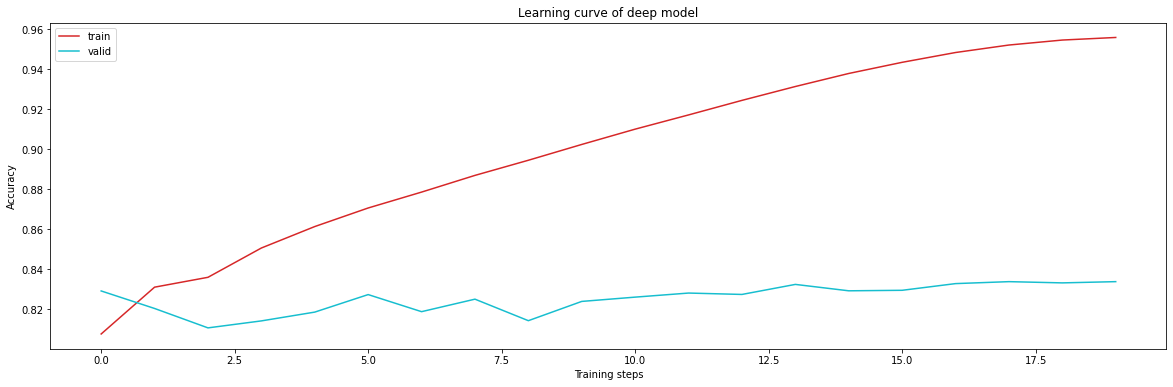

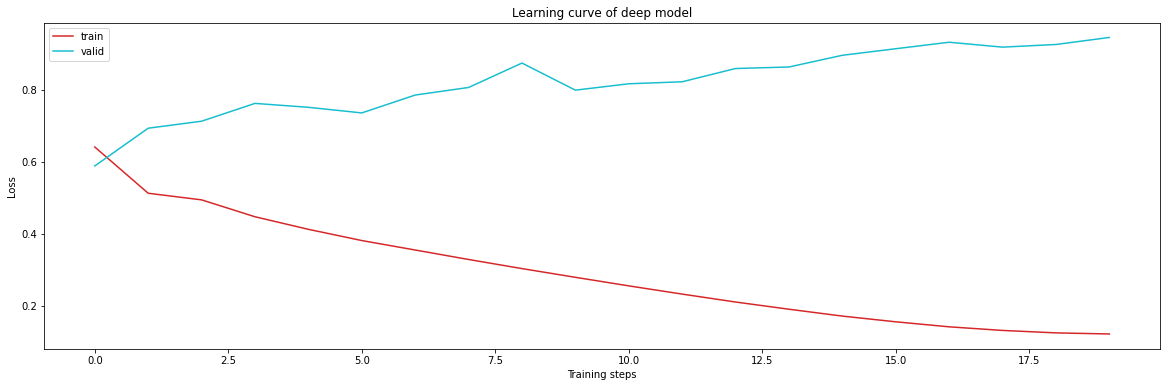

In [29]:
# %%script false --no-raise-error

import matplotlib.pyplot as plt

def plot_cmp(train, valid, ylabel, title):
    total_steps = len(train)
    x_1 = range(total_steps)
    plt.figure(figsize=(20, 6))
    plt.plot(x_1, train, c='tab:red', label='train')
    if len(valid) != 0:
        x_2 = x_1[::len(train) // len(valid)]
        plt.plot(x_2, valid, c='tab:cyan', label='valid')
#     plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

plot_cmp(train_accs, valid_accs, ylabel='Accuracy', title='Learning curve of deep model')
plot_cmp(train_losses, valid_losses, ylabel='Loss', title='Learning curve of deep model')

In [30]:
%%script false --no-raise-error

%reload_ext tensorboard
%tensorboard --logdir=./runs/

## Testing
Create a testing dataset, and load model from the saved checkpoint.

In [31]:
# load data
test_X = preprocess_data(split='test', feat_dir=os.path.join(phone_path, "feat"), phone_path=phone_path, concat_nframes=concat_nframes)
test_set = LibriDataset(test_X, None)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

[Dataset] - # phone classes: 41, number of utterances for test: 1078


1078it [00:17, 62.79it/s]

[INFO] test set
torch.Size([646268, 1989])


In [32]:
# %%script false --no-raise-error

# load model
model = get_model()
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Make prediction.

In [33]:
# %%script false --no-raise-error
import numpy as np

pred = np.array([], dtype=np.int32)

model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        features = batch
        features = features.to(device)

        outputs = model(features)

        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        pred = np.concatenate((pred, test_pred.cpu().numpy()), axis=0)


100%|██████████| 10098/10098 [03:49<00:00, 43.95it/s]


Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [34]:
# %%script false --no-raise-error
if 'acc' not in locals():
    acc = 0.0
    
with open(f'prediction_{acc:.3f}.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(pred):
        f.write('{},{}\n'.format(i, y))

## Ensemble
0.79644

In [35]:
%%script false --no-raise-error

class Classifier_Attn1(nn.Module):
    def __init__(self, concat_nframes, dim_feedforward, num_layers, dropout, d_model=80, output_dim=41):
        super(Classifier_Attn1, self).__init__()
        
        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(39, d_model)
        
        self.positional_encoder = PositionalEncoding(
            dim_model=d_model, dropout_p=dropout, max_len=5000
        )
        
        # (batch, concat_nframes, 39)
        self.attn_layer = nn.TransformerEncoderLayer(
            d_model=d_model, dim_feedforward=dim_feedforward, nhead=1, dropout=dropout, batch_first=True,
        )
        self.attn = nn.TransformerEncoder(self.attn_layer, num_layers=num_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(concat_nframes*d_model, d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Linear(d_model, output_dim),
        )

    def forward(self, x):
        out = x.view(x.shape[0], -1, 39)   # (batch, concat_nframes, 39)
        out = self.prenet(out)             # (batch, concat_nframes, d_model)
        out = self.positional_encoder(out) # (batch, concat_nframes, d_model)
        out = self.attn(out)               # (batch, concat_nframes, d_model)
        out = out.view(out.shape[0], -1)   # (batch, concat_nframes * d_model)
        out = self.fc(out)
        
        return out

In [36]:
%%script false --no-raise-error

# load model
models = []

# model = Classifier(input_dim=39*17, hidden_layers=12, hidden_dim=1024).to(device)
# model.load_state_dict(torch.load("../input/hw02ensemble/model_linear_0.76064_v12.ckpt", map_location=device))
# models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=256, num_layers=12, dropout=0.0, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.75041_v21.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=256, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.77324_v23.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=256, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.77794_v24.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=512, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.77830_v28.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=1024, num_layers=12, dropout=0.25, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.76799_v29.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=1024, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.77872_v30.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=1024, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.77051_v31.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=1024, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.77887_v32.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=1024, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.76904_v33.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn1(concat_nframes=21, dim_feedforward=1024, num_layers=12, dropout=0.1, d_model=80).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.76935_v36.ckpt", map_location=device))
models.append(model)

model = Classifier_Attn(concat_nframes=21, dim_feedforward=2048, num_layers=6, dropout=0.1, d_model=512, nhead=8).to(device)
model.load_state_dict(torch.load("../input/hw02ensemble/model_attn_0.77566_v43.ckpt", map_location=device))
models.append(model)

In [37]:
%%script false --no-raise-error

for model in models:    
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        val_acc = 0
        for i, batch in enumerate(tqdm(val_loader)):
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)

            _, val_pred = torch.max(outputs, 1) 
            val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability

        print(val_acc/len(val_set))

In [38]:
%%script false --no-raise-error

def average_softmax(models, features):
    outputs = torch.zeros(features.shape[0], 41)
    outputs = outputs.to(device)
    for model in models:
        model.eval()
        outputs += F.softmax(model(features), dim=1)
    outputs = outputs/len(models)
    return outputs

def voting(models, features):
    outputs = torch.zeros(features.shape[0], 41)
    outputs = outputs.to(device)
    for model in models:
        model.eval()
        i = range(features.shape[0])
        j = torch.argmax(model(features), dim=1)
        outputs[i,j] += 1
            
    return outputs

In [39]:
%%script false --no-raise-error

pred1 = np.array([], dtype=np.int32)
pred2 = np.array([], dtype=np.int32)

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        features = batch
        features = features.to(device)

        outputs = average_softmax(models, features)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        pred1 = np.concatenate((pred1, test_pred.cpu().numpy()), axis=0)
        
        outputs = voting(models, features)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        pred2 = np.concatenate((pred2, test_pred.cpu().numpy()), axis=0)


In [40]:
%%script false --no-raise-error

with open(f'prediction_average_softmax.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(pred1):
        f.write('{},{}\n'.format(i, y))
        
with open(f'prediction_voting.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(pred2):
        f.write('{},{}\n'.format(i, y))